In [ ]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

In [2]:
import sys
import tensorflow as tf
import tensorflow.keras as keras
print("Python version %s.%s.%s" % sys.version_info[:3])
print("Tensorflow version %s" % tf.__version__)
print("Keras version %s" % keras.__version__)

Python version 3.7.13
Tensorflow version 2.0.0
Keras version 2.2.4-tf


In [3]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet50, vgg16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
%matplotlib inline

model_resnet50 = resnet50.ResNet50(weights='imagenet', include_top=False)
model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)

img_width = 224
# TODO: placeholders actual values are augmentation specific
num_train_images = 1229
split_point = 983

2022-04-14 13:21:44.335211: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 13:21:44.335679: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


In [4]:
labels = pd.read_csv('data/train/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
labels.head()

,id,distancing
0,0001,0
1,0002,1
2,0003,1
3,0004,0
4,0005,0


In [5]:
classes = ['not_distanced', 'distanced']

In [6]:
def get_image(filename):
    original = load_img(filename, target_size=(img_width, img_width))
    numpy_image = img_to_array(original)
    return np.uint8(numpy_image)

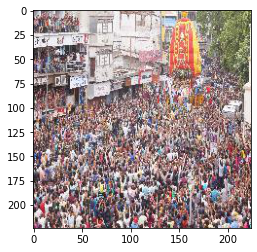

In [8]:
image = get_image('data/train/images/1200.jpg')
plt.imshow(np.uint8(image))
plt.show()

In [9]:
x_train = np.zeros((num_train_images, img_width, img_width, 3), dtype=np.uint8)
y_train = np.zeros((num_train_images, 2), dtype=np.uint8)

for i in range(num_train_images):
    # print('train/%s.jpg' % labels['id'][i])
    x_train[i] = get_image('data/train/images/%s.jpg' % labels['id'][i])
    # print(labels['distancing'][i])
    pos = labels['distancing'][i] # recall that breed is the array of classes
    y_train[i][pos] = 1
    # print(y_train[i])
    if(i % 1000 == 0): print(i, 'images loaded')

0 images loaded
1000 images loaded


In [10]:
num_test_images = 310

x_test = np.zeros((num_test_images, img_width, img_width, 3), dtype=np.uint8)
y_test = np.zeros((num_test_images, 2), dtype=np.uint8)

test_labels = pd.read_csv('data/test/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
test_labels.head()

,id,distancing
0,1230,0
1,1231,1
2,1232,0
3,1233,0
4,1234,1


In [11]:
for i in range(num_test_images):
    # print('test/%s.jpg' % labels['id'][i])
    x_test[i] = get_image('data/test/images/%s.jpg' % test_labels['id'][i])
    # print(test_labels['distancing'][i])
    pos = test_labels['distancing'][i] # recall that breed is the array of classes
    y_test[i][pos] = 1
    # print(y_train[i])
    if(i % 100 == 0): print(i, 'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded


In [59]:
x_train_res = resnet50.preprocess_input(x_train)
res_features = model_resnet50.predict(x_train_res, batch_size=64, verbose=1)
x_train_vgg = vgg16.preprocess_input(x_train)
vgg_features = model_vgg16.predict(x_train_vgg, batch_size=64, verbose=1)

1229/1229 [==============================] - 327s 266ms/sample


In [60]:
res_features.shape

(1229, 7, 7, 2048)

In [61]:
vgg_features.shape

(1229, 7, 7, 512)

In [62]:
concat_features = np.concatenate((res_features, vgg_features), axis=3)
concat_features.shape

(1229, 7, 7, 2560)

In [63]:
inputs = Input(shape = (7, 7, 2560))
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(2, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.

In [64]:
model = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 7, 7, 2560)]      0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               1280500   
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0   

In [65]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [66]:
early_stop = EarlyStopping(monitor='val_loss',  patience=10, verbose=1)

history = model.fit(concat_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(concat_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Train on 983 samples, validate on 246 samples
Epoch 1/30
983/983 [==============================] - 1s 1ms/sample - loss: 0.4353 - accuracy: 0.8037 - val_loss: 0.1139 - val_accuracy: 0.9553
Epoch 2/30
983/983 [==============================] - 0s 375us/sample - loss: 0.1310 - accuracy: 0.9491 - val_loss: 0.1070 - val_accuracy: 0.9675
Epoch 3/30
983/983 [==============================] - 0s 387us/sample - loss: 0.0825 - accuracy: 0.9674 - val_loss: 0.0788 - val_accuracy: 0.9715
Epoch 4/30
983/983 [==============================] - 0s 375us/sample - loss: 0.0722 - accuracy: 0.9746 - val_loss: 0.0425 - val_accuracy: 0.9797
Epoch 5/30
983/983 [==============================] - 0s 364us/sample - loss: 0.0561 - accuracy: 0.9797 - val_loss: 0.0196 - val_accuracy: 0.9959
Epoch 6/30
983/983 [==============================] - 0s 390us/sample - loss: 0.0369 - accuracy: 0.9858 - val_loss: 0.0157 - val_accuracy: 0.9959
Epoch 7/30
983/983 [==============================] - 0s 389us/sample - loss: 0.

In [67]:
model.save('model_combined.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


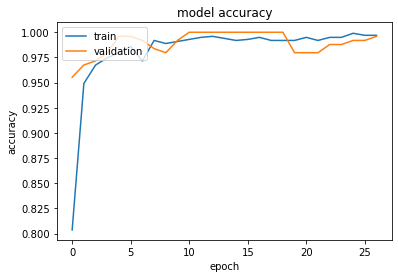

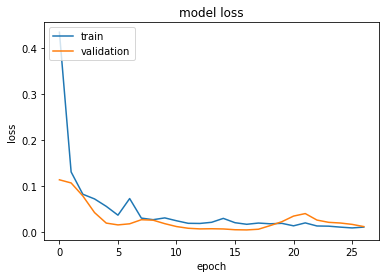

In [68]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

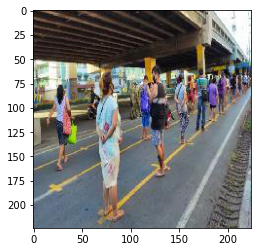

In [69]:
test_img = get_image('data/test/images/1247.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [70]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

x_test_res = resnet50.preprocess_input(image_batch)
res_features = model_resnet50.predict(x_test_res)
x_train_vgg = vgg16.preprocess_input(image_batch)
vgg_features = model_vgg16.predict(x_train_vgg)

concat_features = np.concatenate((res_features, vgg_features), axis=3)

predictions = model.predict(concat_features)
pos = np.argmax(predictions)
classes[pos]

'distanced'

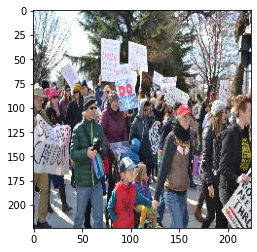

In [71]:
test_img = get_image('data/test/images/1232.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [72]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

x_test_res = resnet50.preprocess_input(image_batch)
res_features = model_resnet50.predict(x_test_res)
x_train_vgg = vgg16.preprocess_input(image_batch)
vgg_features = model_vgg16.predict(x_train_vgg)

concat_features = np.concatenate((res_features, vgg_features), axis=3)

predictions = model.predict(concat_features)
pos = np.argmax(predictions)
classes[pos]

'not_distanced'

In [73]:
x_test_res = resnet50.preprocess_input(x_test)
res_features = model_resnet50.predict(x_test_res)
x_test_vgg = vgg16.preprocess_input(x_test)
vgg_features = model_vgg16.predict(x_test_vgg)

concat_features = np.concatenate((res_features, vgg_features), axis=3)

predictions = model.predict(concat_features)
type(predictions)

numpy.ndarray

In [74]:
preds = np.zeros((num_test_images, 2), dtype=np.uint8)
preds[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1
preds = np.nonzero(preds)
preds = preds[1]
preds[:5]

array([0, 1, 0, 0, 1])

In [75]:
y_truth = np.zeros((num_test_images, 2), dtype=np.uint8)
y_truth[np.arange(y_test.shape[0]), np.argmax(y_test, axis=1)] = 1
y_truth = np.nonzero(y_truth)
y_truth = y_truth[1]
y_truth[:5]

array([0, 1, 0, 0, 1])

In [76]:
matrix = confusion_matrix(y_truth, preds)
print(matrix)

[[194   6]
 [ 10 100]]


In [77]:
precision = precision_score(y_truth, preds)
print('Precision: %f' % precision)
recall = recall_score(y_truth, preds)
print('Recall: %f' % recall)
f1 = f1_score(y_truth, preds)
print('F1 score: %f' % f1)

Precision: 0.943396
Recall: 0.909091
F1 score: 0.925926


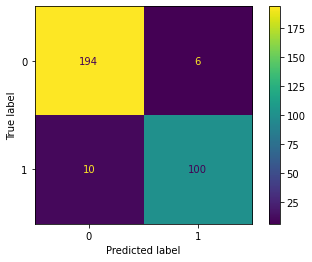

In [78]:
ConfusionMatrixDisplay.from_predictions(y_truth, preds)